<a href="https://colab.research.google.com/github/jagan-lakshmipathy/DO180-apps/blob/master/FirstNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1S-z8nvTAYeBwRsQCGAlDloooNqt31T8M'
outfile = 'X_label.csv'
gdown.download(url, outfile, quiet=True)

'X_label.csv'

In [ ]:
url = 'https://drive.google.com/uc?id=1qtzN3qcusdHCe2zcM-hgXW19lW8FsHr8'
outfile = 'X_train.pq'
start_time = time.time()
gdown.download(url, outfile, quiet=True)
print("Time taken:", time.time() - start_time)

Time taken: 43.02639293670654


In [ ]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import cv2
import os
import zipfile
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import time
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import timeit

In [ ]:
def timeit(f):
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func:{f.__name__} args:[{args}, {kw}] took: {te-ts:2.4f} sec')        
        return result
    return wrap

In [ ]:
@timeit
def load():
  path = pathlib.Path('/content/X_train.pq')
  table = pq.read_table(str(path))
  table = table.to_pandas().to_numpy()
  return table

In [ ]:
X_train = load()

func:load args:[(), {}] took: 37.1649 sec


In [ ]:
y_train = np.array(pd.read_csv(pathlib.Path('/content/X_label.csv')))
y_train

array([['del'],
       ['del'],
       ['del'],
       ...,
       ['Z'],
       ['Z'],
       ['Z']], dtype=object)

In [19]:
import warnings
warnings.filterwarnings('ignore')

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [23]:
print(os.getcwd())
#os.chdir('archive/asl_alphabet_train/asl_alphabet_train')
os.listdir()
train_path = '/content/ASL_Data_40K/archive_40k/asl_alphabet_train/asl_alphabet_train/'
test_path = '/content/ASL_Data_40K/archive_40k/asl_alphabet_test/asl_alphabet_test/'

/content


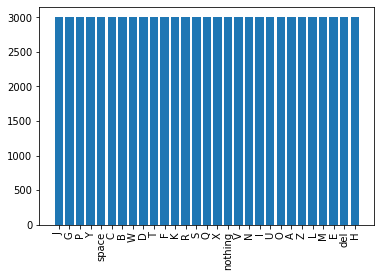

In [24]:
classes = os.listdir(train_path)
nos = []
for i in classes:
    nos.append(len(os.listdir(train_path+i)))
    
plt.bar(classes, nos)
plt.xticks(rotation = 90)

plt.show()

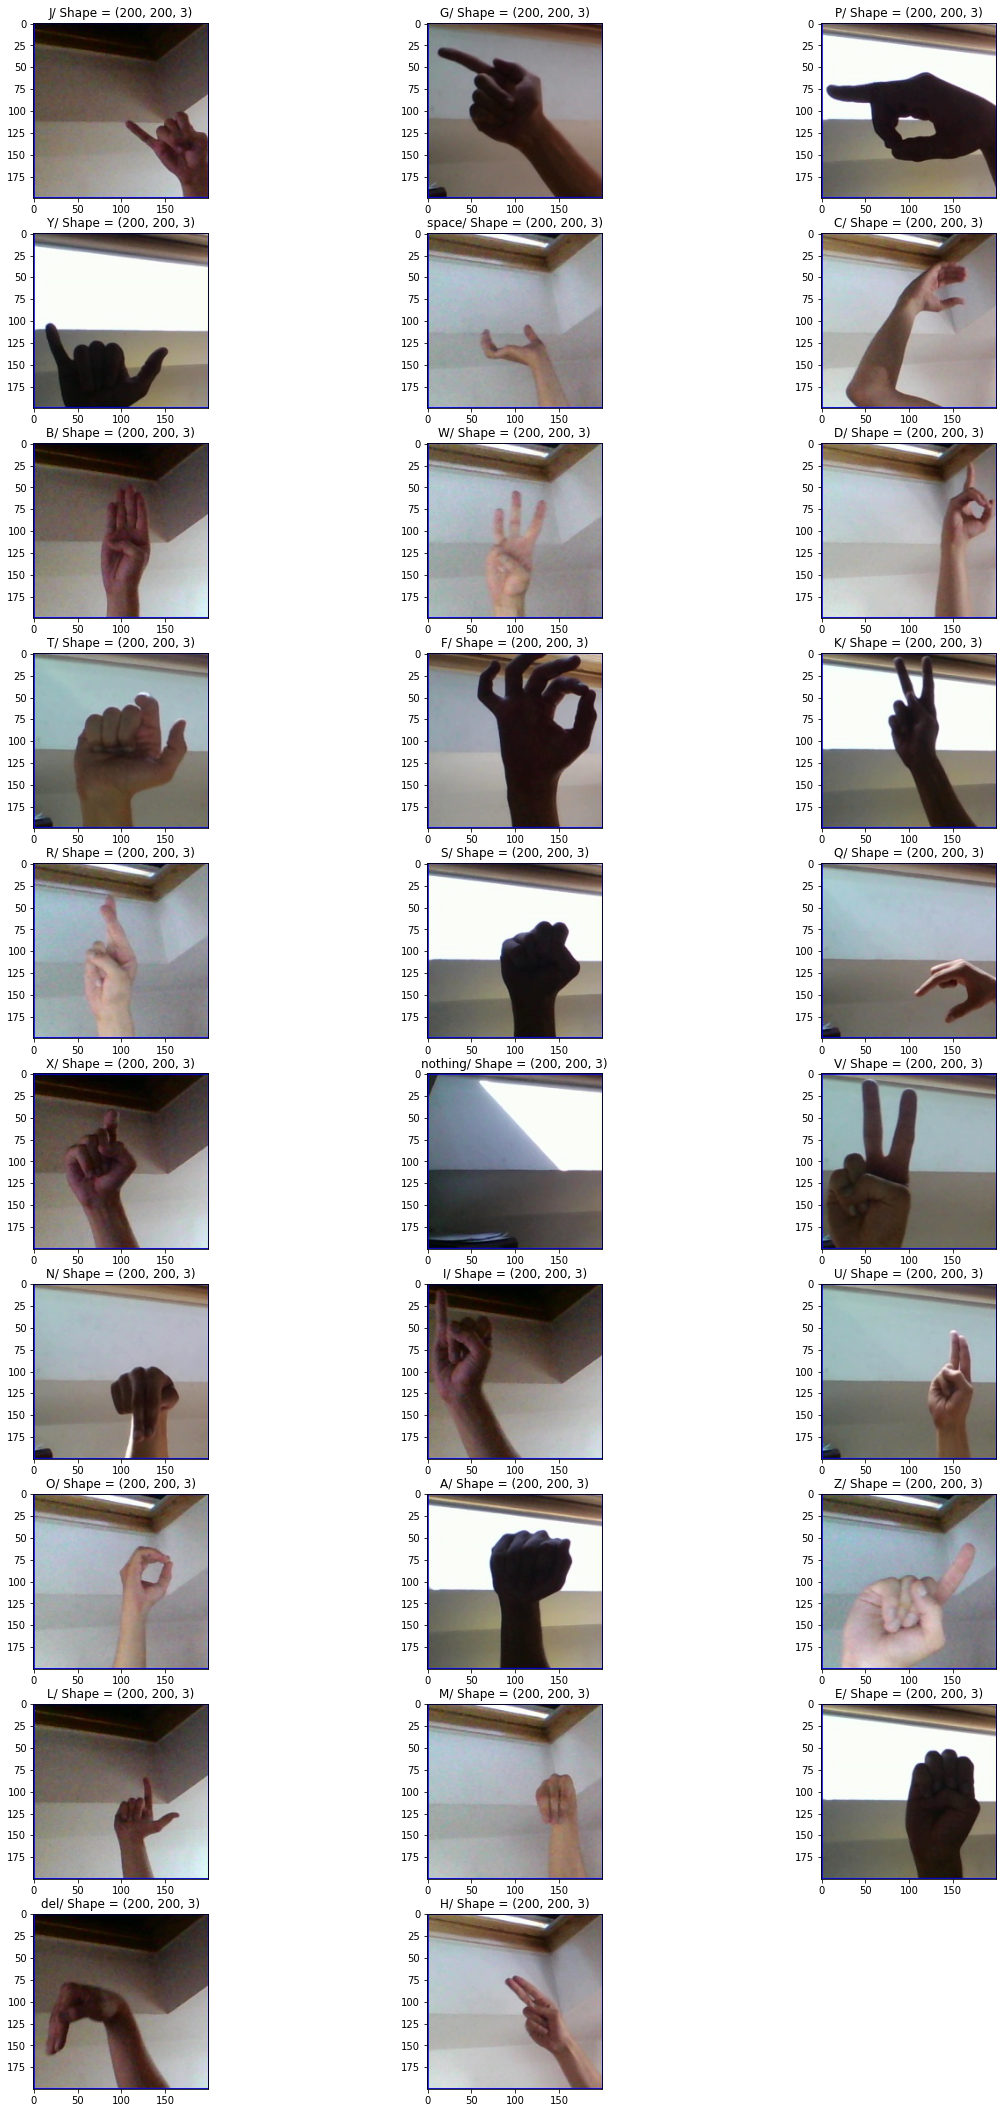

In [25]:
plt.figure(figsize=(20,38))
for i in enumerate(classes):
    image = os.listdir(train_path+i[1])[0]
    image = Image.open(train_path+i[1]+'/'+image)
    image = np.asarray(image)
    plt.subplot(10,3,i[0]+1)
    plt.imshow(image)
    plt.title('{0}/ Shape = {1}'.format(i[1], image.shape))
plt.show()

In [27]:

# Defining the model

def get_model():
    base_model = InceptionResNetV2(include_top=False, input_shape=(200,200,3))
    
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(len(classes), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

In [28]:
model = get_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
___________________________

In [29]:
# Creating train and validation sets

datagen = ImageDataGenerator(rescale=1/255, validation_split=0.3)

train = datagen.flow_from_directory(train_path, subset='training')
val = datagen.flow_from_directory(train_path, subset='validation')

Found 60900 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.


In [30]:
# Training and validating the model
model.fit(train, epochs=2, batch_size=100, validation_data=val)

Epoch 1/2
1904/1904 [==============================] - 6831s 4s/step - loss: 0.1117 - accuracy: 0.9686 - val_loss: 0.6730 - val_accuracy: 0.8774
Epoch 2/2
1904/1904 [==============================] - 6724s 4s/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.2421 - val_accuracy: 0.9416


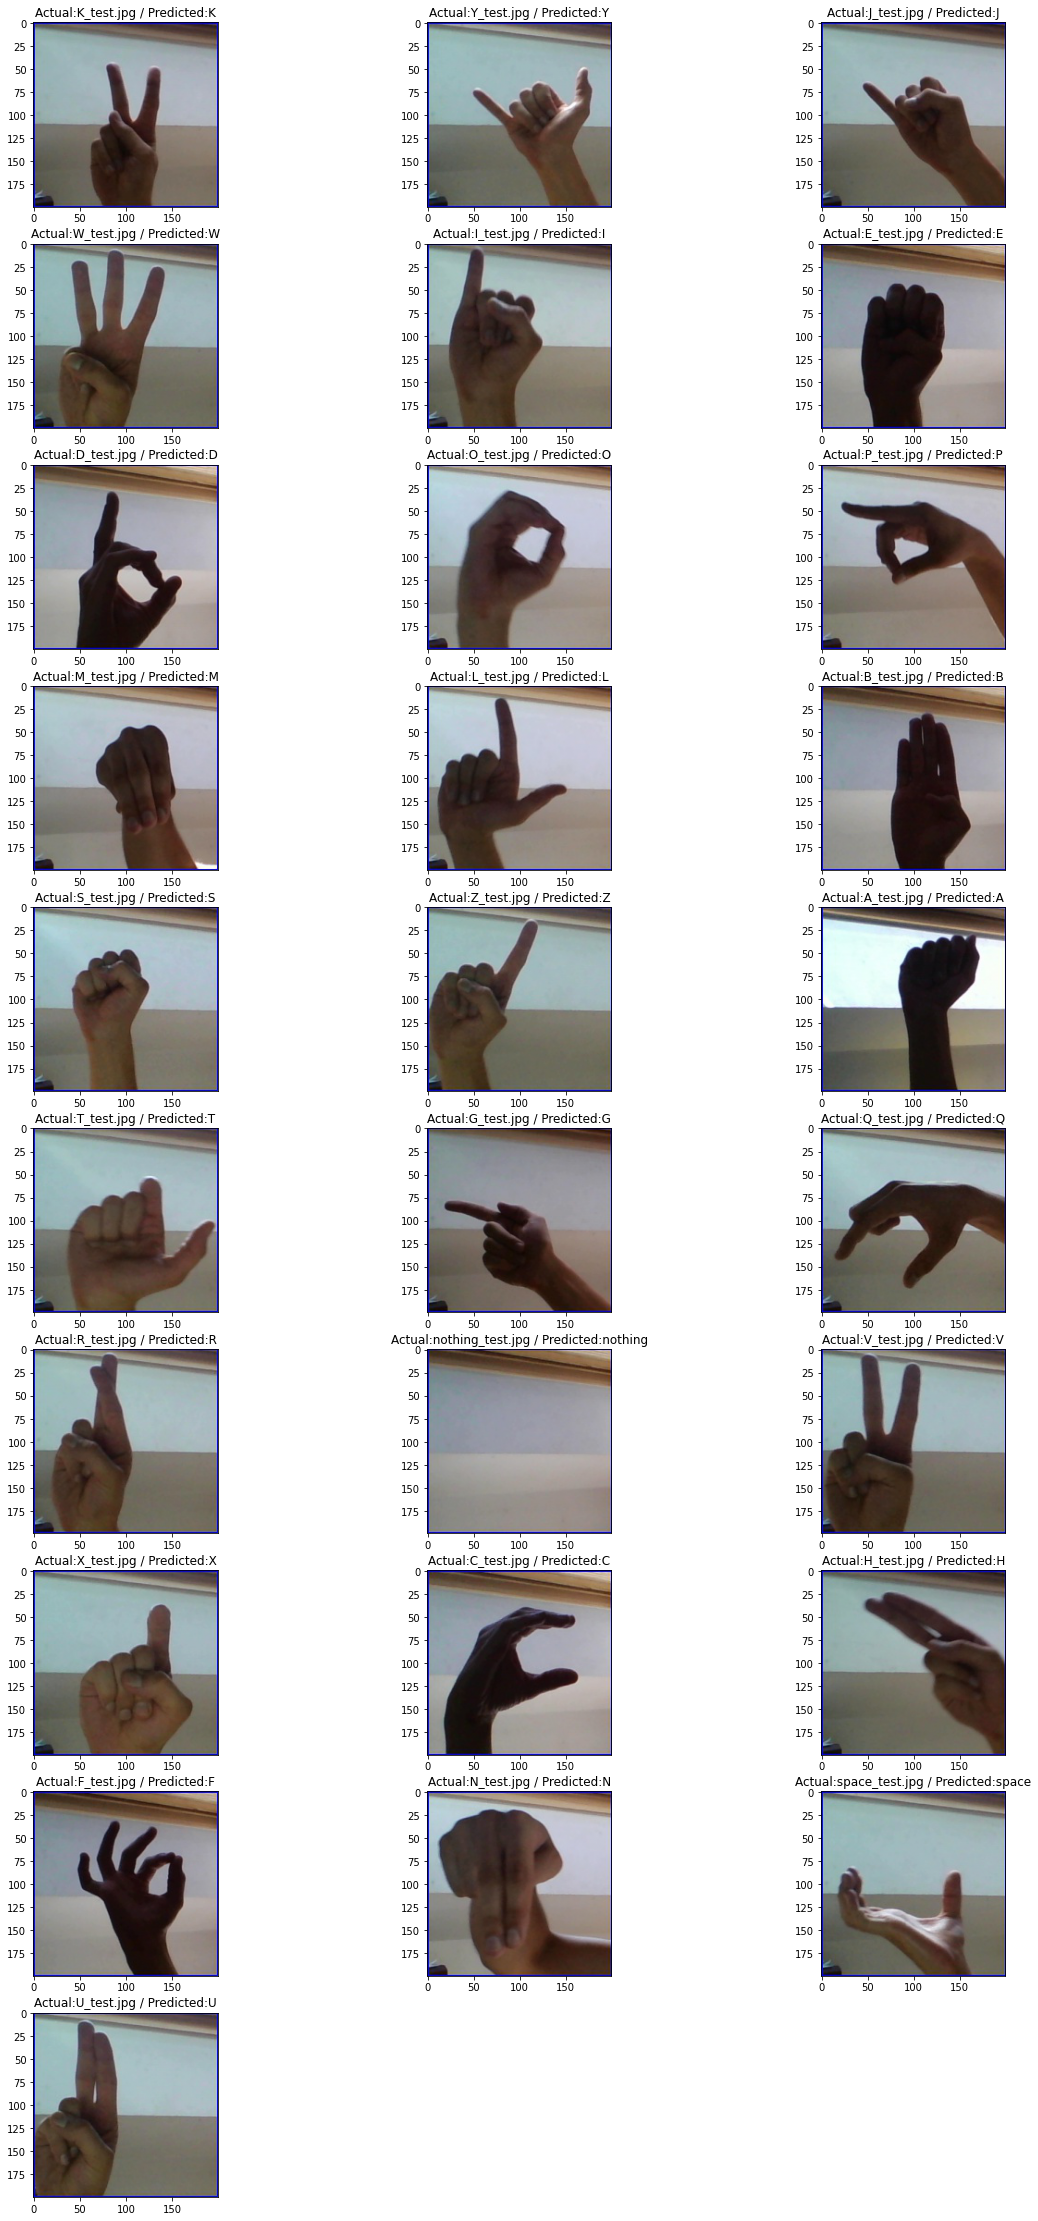

In [31]:
plt.figure(figsize=(20,40))
for i in enumerate(os.listdir(test_path)):
    image = Image.open(test_path+'/'+i[1])
    image = np.asarray(image)
    image = image/255
    
    plt.subplot(10,3,i[0]+1)
    plt.imshow(image)
    
    pred = np.argmax(model.predict(image.reshape(-1,200,200,3)))
    for j in train.class_indices:
        if pred == train.class_indices[j]:
            prediction=j
        else:
            continue
    
    plt.title('Actual:{0} / Predicted:{1}'.format(i[1],prediction))